###### .
## <center>CSE 546: Reinforcement Learning</center>
### <center>Prof. Alina Vereshchaka</center>
#### <center>Fall 2025</center>

## Setup

In [4]:
# install libs
!pip install gymnasium stable-baselines3 shimmy pygame

# unzip env
!unzip -o wildfire-env_og.zip

Archive:  wildfire-env_og.zip
   creating: wildfire-env/
  inflating: wildfire-env/evaluate_v0.ipynb  
  inflating: wildfire-env/train_v0.ipynb  
  inflating: wildfire-env/.DS_Store  
  inflating: __MACOSX/wildfire-env/._.DS_Store  
  inflating: wildfire-env/LICENSE    
  inflating: wildfire-env/ppo_fire_squad_coop_v0.zip  
  inflating: wildfire-env/train_greedy_v0.ipynb  
   creating: wildfire-env/dist/
  inflating: wildfire-env/train_greedy.ipynb  
  inflating: wildfire-env/pyproject.toml  
  inflating: wildfire-env/evaluate.ipynb  
   creating: wildfire-env/docs/
  inflating: wildfire-env/README.md  
  inflating: wildfire-env/firecast.ipynb  
  inflating: wildfire-env/.gitignore  
   creating: wildfire-env/firecastrl_env/
   creating: wildfire-env/.ipynb_checkpoints/
  inflating: wildfire-env/train.ipynb  
   creating: wildfire-env/.git/
  inflating: wildfire-env/dist/firecastrl_env-0.1.2-py3-none-any.whl  
  inflating: wildfire-env/dist/firecastrl_env-0.1.2.tar.gz  
  inflating: wi

## Mounting DRIVE(to save models and plots) & Fix Paths(to include our firecast_env)

In [5]:
import sys
import os
import shutil
from google.colab import drive

# mount drive for saving
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/FirecastRL_Models"
os.makedirs(save_dir, exist_ok=True)

# fix package naming issue
if os.path.exists("wildfire-env"):
    if os.path.exists("wildfire-env/firecastrl_env"):
        sys.path.append(os.path.abspath("wildfire-env"))
    else:
        if os.path.exists("firecastrl_env"):
            shutil.rmtree("firecastrl_env")
        os.rename("wildfire-env", "firecastrl_env")
        sys.path.append(os.path.abspath("."))

# check import
try:
    from firecastrl_env.envs.wildfire_env import WildfireEnv
    print("env imported ok")
except ImportError as e:
    print(f"import error: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
env imported ok


## Wrappers

In [6]:
import gymnasium as gym
import numpy as np
from firecastrl_env.envs.environment import helper
from firecastrl_env.envs.environment.enums import FireState

# fix infs in obs cause sb3 crashes otherwise
class SafeWildfireWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    def observation(self, obs):
        if 'cells' in obs:
            obs['cells'] = np.nan_to_num(obs['cells'], posinf=-1.0)
        return obs

# reward wrapper for coop vs greedy logic
class MultiAgentRewardWrapper(gym.Wrapper):
    def __init__(self, env, mode="cooperative"):
        super().__init__(env)
        self.mode = mode.lower()

    def step(self, action):
        obs, _, term, trunc, info = self.env.step(action)

        # switch reward calc based on mode
        if self.mode == "cooperative":
            rew = self._calc_coop(info, obs)
        else:
            rew = self._calc_comp(info)

        return obs, float(rew), term, trunc, info

    def _calc_coop(self, info, obs):
        # global penalty for fire existing
        curr_burn = info['cells_burning']
        extinguished = obs['quenched_cells'][0]

        r = 0.0
        r += 10.0 * extinguished
        r -= 0.1 * curr_burn # team penalty
        r -= self._check_waste()

        return np.clip(r, -50.0, 50.0)

    def _calc_comp(self, info):
        # greedy. no penalty for fire spread
        waste = self._check_waste()
        extinguished = self.env.unwrapped.state['quenched_cells'][0]

        r = 0.0
        r += 10.0 * extinguished
        r -= waste

        return np.clip(r, -50.0, 50.0)

    def _check_waste(self):
        # penalty if dropping water on empty cell
        pen = 0.0
        base = self.env.unwrapped

        for i in range(base.num_agents):
            act = base.state['last_action'][i]
            x, y = base.state['helicopter_coord'][i]

            if act == 4:
                idx = helper.get_grid_index_for_location(x, y, base.gridWidth)
                c = base.cells[idx]

                if c.fireState != FireState.Burning:
                    pen += 2.0
        return pen

## Training Experiment A (Co-op)

In [7]:
from stable_baselines3 import PPO
from firecastrl_env.envs.wildfire_env import WildfireEnv

print("starting coop training")

# init envs
raw_env = WildfireEnv(num_agents=3, render_mode=None)
safe_env = SafeWildfireWrapper(raw_env)
env = MultiAgentRewardWrapper(safe_env, mode="cooperative")

# training
model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

# save
path = f"{save_dir}/ppo_fire_squad_coop"
model.save(path)
print(f"saved coop model to {path}")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


starting coop training
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 606       |
|    ep_rew_mean     | -3.54e+03 |
| time/              |           |
|    fps             | 29        |
|    iterations      | 1         |
|    time_elapsed    | 68        |
|    total_timesteps | 2048      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 668         |
|    ep_rew_mean          | -3.75e+03   |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 2           |
|    time_elapsed         | 132         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008035254 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.82       |
|    explained_variance   | -0.0126     |
|    learning_rate        | 0.0003      |
|    loss                 | 4.03e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00926    |
|    value_loss           | 9.23e+03    |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 653 

## Train Experiment B (Greedy)

In [8]:
print("starting greedy training")

# reset env stack for greedy
raw = WildfireEnv(num_agents=3, render_mode=None)
safe = SafeWildfireWrapper(raw)
env = MultiAgentRewardWrapper(safe, mode="competitive")

# training
model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

# save
path = f"{save_dir}/ppo_fire_squad_greedy"
model.save(path)
print(f"saved greedy model to {path}")

starting greedy training
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 495      |
|    ep_rew_mean     | -611     |
| time/              |          |
|    fps             | 31       |
|    iterations      | 1        |
|    time_elapsed    | 66       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 548         |
|    ep_rew_mean          | -586        |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 2           |
|    time_elapsed         | 126         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022914918 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2     

## Evaluation

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

NUM_EPS = 10

def run_eval( path, name):
    print(f"evaluating {name}...")

    # physics only env
    raw = WildfireEnv(num_agents=3, render_mode=None)
    env = SafeWildfireWrapper(raw)

    try:
        model = PPO.load(path)
    except:
        print("model not found")
        return None, None

    stats = []
    curves = []

    for i in range(NUM_EPS):
        obs, _ = env.reset()
        done = False
        step = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, term, trunc, info = env.step(action)
            done = term or trunc

            curves.append({
                "Agent": name,
                "Ep": i,
                "Step": step,
                "FireSize": info['cells_burning']
            })
            step += 1

        stats.append({
            "Agent": name,
            "Ep": i,
            "Burnt": info['cells_burnt'],
            "Quenched": obs['quenched_cells'][0]
        })
        print(f"ep {i}: burnt {info['cells_burnt']}")

    return pd.DataFrame(stats), pd.DataFrame(curves)

# paths
p_coop = f"{save_dir}/ppo_fire_squad_coop"
p_comp = f"{save_dir}/ppo_fire_squad_greedy"

# run
s_coop, c_coop = run_eval(p_coop, "Cooperative")
s_comp, c_comp = run_eval(p_comp, "Greedy")

if s_coop is not None and s_comp is not None:
    df_stats = pd.concat([s_coop, s_comp])
    df_curves = pd.concat([c_coop, c_comp])
    print("data collected")

evaluating Cooperative...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ep 0: burnt 1592
ep 1: burnt 301
ep 2: burnt 1640
ep 3: burnt 1159
ep 4: burnt 1592
ep 5: burnt 1441
ep 6: burnt 301
ep 7: burnt 1441
ep 8: burnt 1592
ep 9: burnt 301
evaluating Greedy...
ep 0: burnt 1159
ep 1: burnt 1441
ep 2: burnt 751
ep 3: burnt 1592
ep 4: burnt 1592
ep 5: burnt 1159
ep 6: burnt 1592
ep 7: burnt 301
ep 8: burnt 1640
ep 9: burnt 1441
data collected


## Fire Damage Comparison - Box Plot

/tmp/ipython-input-3701379430.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_stats, x="Agent", y="Burnt", palette="Set2")
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


plot saved /content/drive/MyDrive/FirecastRL_Models/plot_damage.png


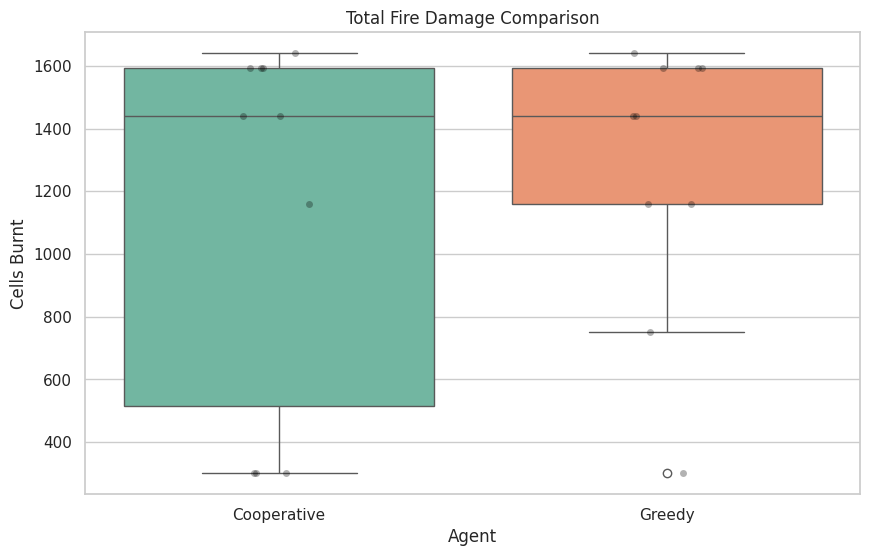

In [10]:
if 'df_stats' in locals():
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # boxplot for dmg
    sns.boxplot(data=df_stats, x="Agent", y="Burnt", palette="Set2")
    sns.stripplot(data=df_stats, x="Agent", y="Burnt", color="black", alpha=0.3)

    plt.title("Total Fire Damage Comparison")
    plt.ylabel("Cells Burnt")

    # save
    p = f"{save_dir}/plot_damage.png"
    plt.savefig(p, dpi=300, bbox_inches='tight')
    print(f"plot saved {p}")
    plt.show()

## Fire Speed - line plot

plot saved /content/drive/MyDrive/FirecastRL_Models/plot_speed.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


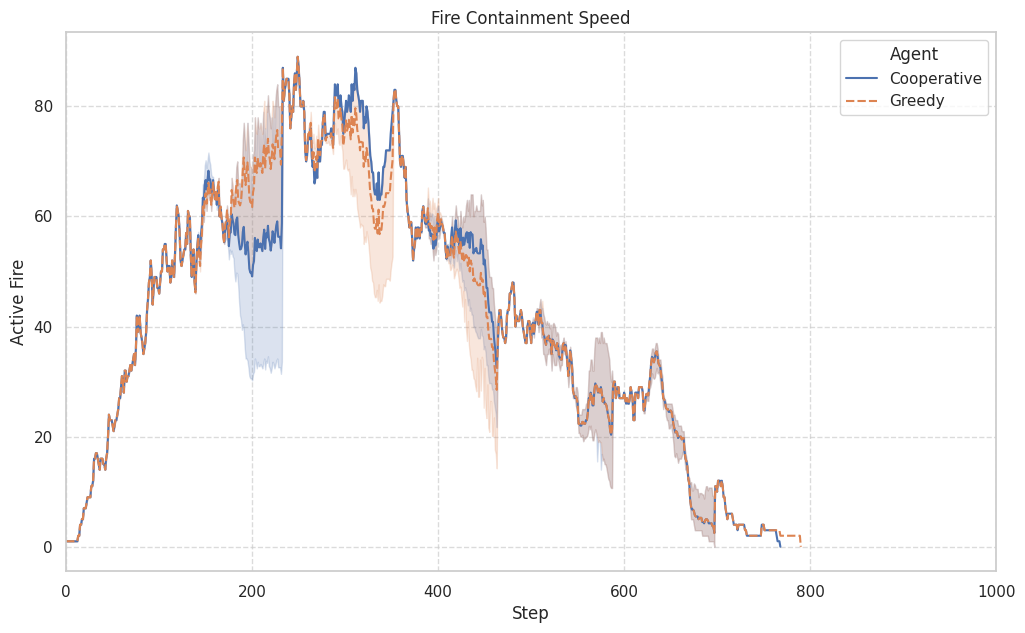

In [11]:
if 'df_curves' in locals():
    plt.figure(figsize=(12, 7))

    # containment speed
    sns.lineplot(data=df_curves, x="Step", y="FireSize", hue="Agent", style="Agent")

    plt.title("Fire Containment Speed")
    plt.ylabel("Active Fire")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1000)

    p = f"{save_dir}/plot_speed.png"
    plt.savefig(p, dpi=300, bbox_inches='tight')
    print(f"plot saved {p}")
    plt.show()

## Efficiency Analysis - Scatter Plot

plot saved /content/drive/MyDrive/FirecastRL_Models/plot_efficiency.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


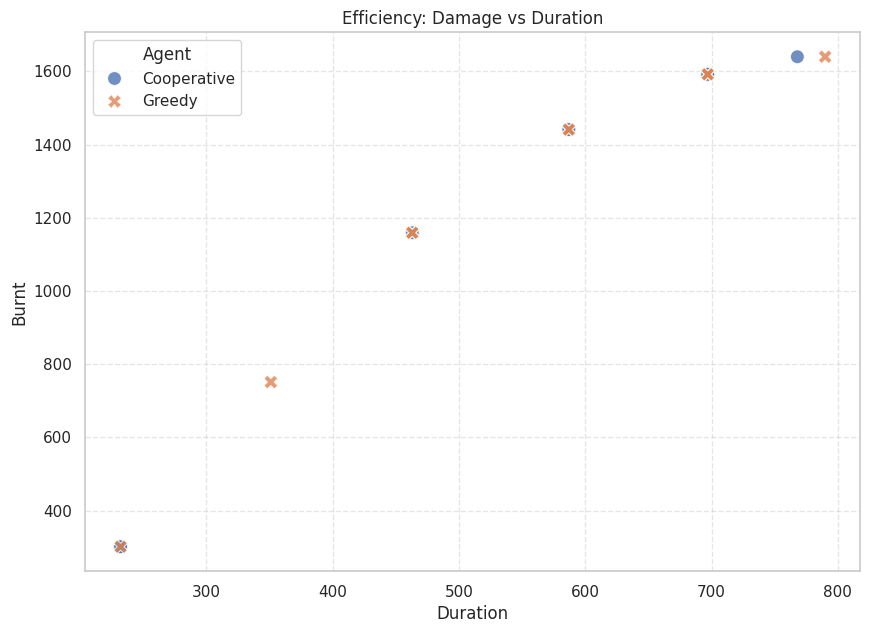

In [12]:
if 'df_stats' in locals():
    plt.figure(figsize=(10, 7))

    # get duration per ep
    durs = df_curves.groupby(['Agent', 'Ep'])['Step'].max().reset_index()
    durs.rename(columns={'Step': 'Duration'}, inplace=True)

    merged = pd.merge(df_stats, durs, on=['Agent', 'Ep'])

    # efficiency plot
    sns.scatterplot(
        data=merged, x="Duration", y="Burnt",
        hue="Agent", style="Agent", s=100, alpha=0.8
    )

    plt.title("Efficiency: Damage vs Duration")
    plt.grid(True, linestyle='--', alpha=0.5)

    p = f"{save_dir}/plot_efficiency.png"
    plt.savefig(p, dpi=300, bbox_inches='tight')
    print(f"plot saved {p}")
    plt.show()

## Risk Profile - Kernel Density Estimate Plot

plot saved /content/drive/MyDrive/FirecastRL_Models/plot_risk.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


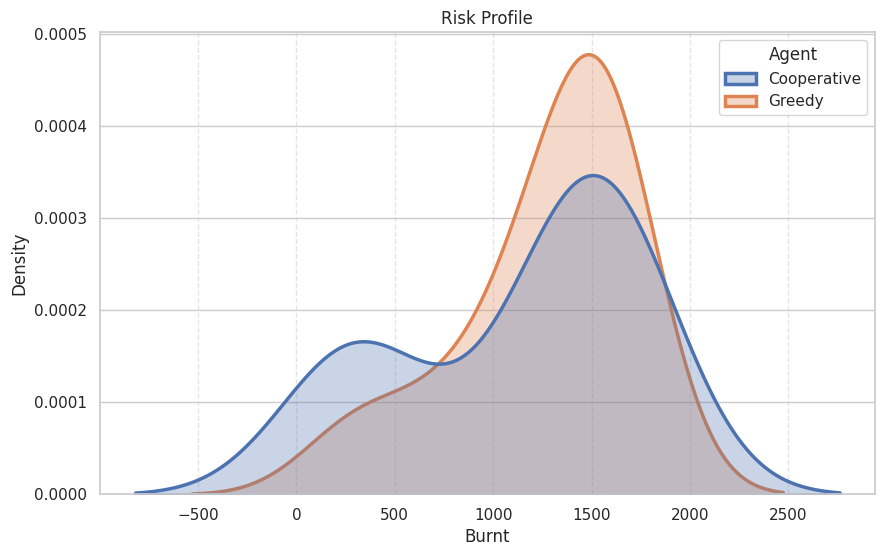

In [13]:
if 'df_stats' in locals():
    plt.figure(figsize=(10, 6))

    # kde for risk profile
    sns.kdeplot(
        data=df_stats, x="Burnt", hue="Agent",
        fill=True, alpha=0.3, linewidth=2.5
    )

    plt.title("Risk Profile")
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    p = f"{save_dir}/plot_risk.png"
    plt.savefig(p, dpi=300, bbox_inches='tight')
    print(f"plot saved {p}")
    plt.show()

## Final Summary Stats

In [14]:
if 'df_stats' in locals():
    # merge duration info
    durs = df_curves.groupby(['Agent', 'Ep'])['Step'].max().reset_index()
    final = pd.merge(df_stats, durs, on=['Agent', 'Ep'])

    # agg stats
    print(final.groupby("Agent").agg({
        "Burnt": ["mean", "std", "min", "max"],
        "Step": ["mean"]
    }).round(2))

              Burnt                      Step
               mean     std  min   max   mean
Agent                                        
Cooperative  1136.0  592.18  301  1640  519.2
Greedy       1266.8  439.61  301  1640  556.4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Experiment C (Advanced Setup)

In [15]:
from stable_baselines3.common.callbacks import BaseCallback

# dynamic reward wrapper
class CurriculumRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.coop_weight = 0.0 # starts at 0 (greedy)

    def set_weight(self, w):
        self.coop_weight = np.clip(w, 0.0, 1.0)

    def step(self, action):
        obs, _, term, trunc, info = self.env.step(action)

        # mix of greedy and coop based on weight
        # greedy part
        waste = self._check_waste()
        ext = self.env.unwrapped.state['quenched_cells'][0]
        r_greedy = (10.0 * ext) - waste

        # coop part (global penalty)
        burn = info['cells_burning']
        r_coop = -0.1 * burn

        # curriculum formula: (1-w)*Greedy + w*Coop
        # note: we keep greedy reward always active to maintain aim
        # we just fade IN the global penalty
        final_r = r_greedy + (self.coop_weight * r_coop)

        return obs, float(final_r), term, trunc, info

    def _check_waste(self):
        # reused logic from before
        pen = 0.0
        base = self.env.unwrapped
        for i in range(base.num_agents):
            if base.state['last_action'][i] == 4:
                x, y = base.state['helicopter_coord'][i]
                idx = helper.get_grid_index_for_location(x, y, base.gridWidth)
                if base.cells[idx].fireState != FireState.Burning:
                    pen += 2.0
        return pen

# callback to update weight
class CurriculumCallback(BaseCallback):
    def __init__(self, total_steps):
        super().__init__(0)
        self.total_steps = total_steps

    def _on_step(self):
        # linear ramp from 0.0 to 1.0 over training
        progress = self.num_timesteps / self.total_steps

        # access wrapper (env -> vec_env -> wrapper)
        # sb3 wraps envs deeply, need to unwrap carefully or iterate
        env_ref = self.training_env.envs[0]

        # find our wrapper in the stack
        while not isinstance(env_ref, CurriculumRewardWrapper) and hasattr(env_ref, 'env'):
            env_ref = env_ref.env

        if isinstance(env_ref, CurriculumRewardWrapper):
            env_ref.set_weight(progress)

        return True

## Training Curriculum Agent

In [16]:
print("starting curriculum training (exp c)")

# init
raw_c = WildfireEnv(num_agents=3, render_mode=None)
safe_c = SafeWildfireWrapper(raw_c)
curr_env = CurriculumRewardWrapper(safe_c)

# train with callback
model_curr = PPO("MultiInputPolicy", curr_env, verbose=1)
callback = CurriculumCallback(total_steps=100_000)

model_curr.learn(total_timesteps=100_000, callback=callback)

# save
path_curr = f"{save_dir}/ppo_fire_squad_curriculum"
model_curr.save(path_curr)
print(f"saved curriculum model to {path_curr}")

starting curriculum training (exp c)
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 498      |
|    ep_rew_mean     | -594     |
| time/              |          |
|    fps             | 34       |
|    iterations      | 1        |
|    time_elapsed    | 59       |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 495       |
|    ep_rew_mean          | -552      |
| time/                   |           |
|    fps                  | 33        |
|    iterations           | 2         |
|    time_elapsed         | 123       |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0179313 |
|    clip_fraction        | 0.24      |
|    clip_range           | 0.2       |
|    ent

## Evaluating all Experiments

In [19]:
# load paths
p_coop = f"{save_dir}/ppo_fire_squad_coop"
p_greedy = f"{save_dir}/ppo_fire_squad_greedy"
p_curr = f"{save_dir}/ppo_fire_squad_curriculum"

# run eval loop
df_coop, c_coop = run_eval(p_coop, "Cooperative")
df_greedy, c_greedy = run_eval(p_greedy, "Greedy")
df_curr, c_curr = run_eval(p_curr, "Curriculum")

# combine valid results
stats_list = []
curves_list = []

if df_coop is not None:
    stats_list.append(df_coop)
    curves_list.append(c_coop)

if df_greedy is not None:
    stats_list.append(df_greedy)
    curves_list.append(c_greedy)

if df_curr is not None:
    stats_list.append(df_curr)
    curves_list.append(c_curr)

# concat
if stats_list:
    full_stats_all = pd.concat(stats_list)
    full_curves_all = pd.concat(curves_list)

    print("\n--- grand comparison ---")
    print(full_stats_all.groupby("Agent").agg({
        "Burnt": ["mean", "std", "min"],
        "Quenched": ["mean"]
    }).round(2))
else:
    print("no models found")

evaluating Cooperative...
ep 0: burnt 1441
ep 1: burnt 1159
ep 2: burnt 1592
ep 3: burnt 1592
ep 4: burnt 1159
ep 5: burnt 1640
ep 6: burnt 1441
ep 7: burnt 1592
ep 8: burnt 1441
ep 9: burnt 1441
evaluating Greedy...
ep 0: burnt 301
ep 1: burnt 751
ep 2: burnt 1159
ep 3: burnt 1159
ep 4: burnt 1640
ep 5: burnt 1592
ep 6: burnt 1441
ep 7: burnt 1640
ep 8: burnt 1159
ep 9: burnt 1592
evaluating Curriculum...
ep 0: burnt 1159
ep 1: burnt 1640
ep 2: burnt 1441
ep 3: burnt 1159
ep 4: burnt 1640
ep 5: burnt 1441
ep 6: burnt 1592
ep 7: burnt 1441
ep 8: burnt 301
ep 9: burnt 1159

--- grand comparison ---
              Burnt               Quenched
               mean     std   min     mean
Agent                                     
Cooperative  1449.8  172.01  1159      0.0
Curriculum   1297.3  399.12   301      0.0
Greedy       1243.4  440.78   301      0.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/tmp/ipython-input-797686972.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_stats_all, x="Agent", y="Burnt", palette="viridis")
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


saved /content/drive/MyDrive/FirecastRL_Models/all_plot_damage.png


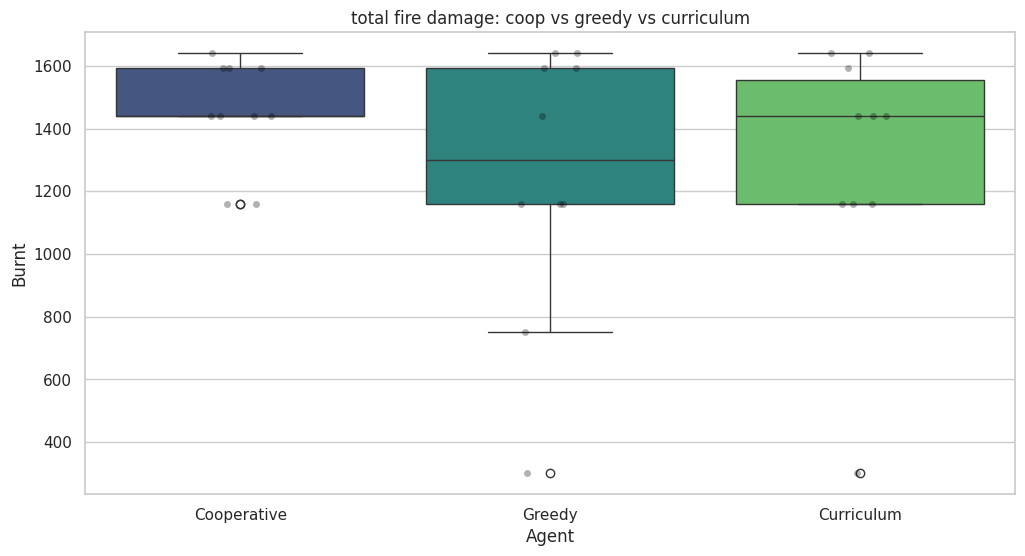

saved /content/drive/MyDrive/FirecastRL_Models/all_plot_speed.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


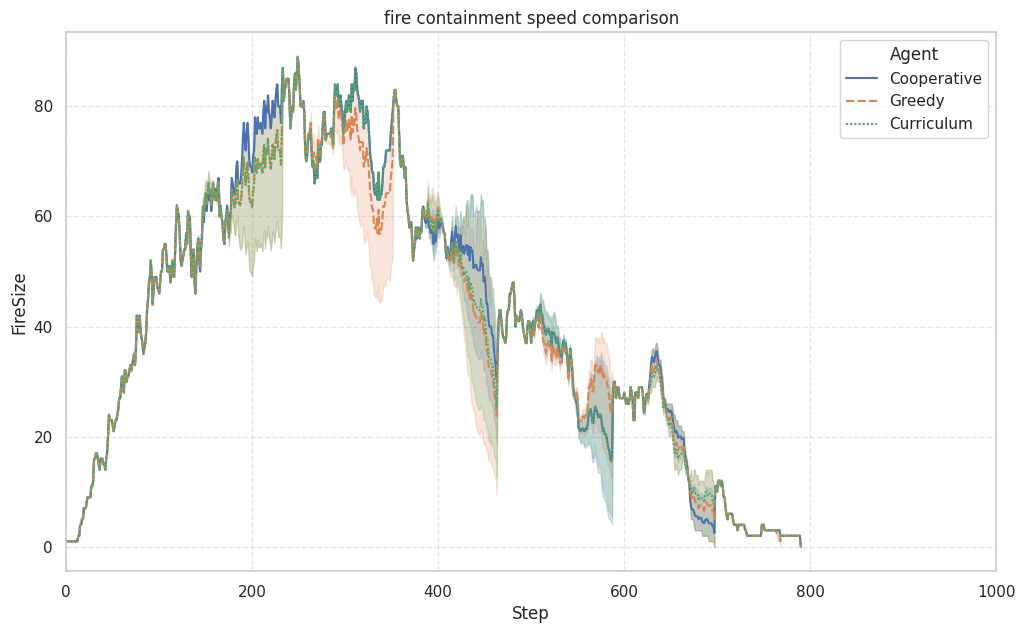

In [20]:
if 'full_stats_all' in locals():
    sns.set_theme(style="whitegrid")

    # 1. damage comparison
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=full_stats_all, x="Agent", y="Burnt", palette="viridis")
    sns.stripplot(data=full_stats_all, x="Agent", y="Burnt", color="black", alpha=0.3)
    plt.title("total fire damage: coop vs greedy vs curriculum")

    p1 = f"{save_dir}/all_plot_damage.png"
    plt.savefig(p1, dpi=300, bbox_inches='tight')
    print(f"saved {p1}")
    plt.show()

    # 2. speed comparison
    plt.figure(figsize=(12, 7))

    sns.lineplot(data=full_curves_all, x="Step", y="FireSize", hue="Agent", style="Agent")
    plt.title("fire containment speed comparison")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, 1000)

    p2 = f"{save_dir}/all_plot_speed.png"
    plt.savefig(p2, dpi=300, bbox_inches='tight')
    print(f"saved {p2}")
    plt.show()